In [225]:
from tableauscraper import TableauScraper as TS

url = "https://visualizedata.ucop.edu/t/Public/views/TransferbyCCM/Bymajorname"

ts = TS()
ts.loads(url)
workbook = ts.getWorkbook()

for t in workbook.worksheets:
    # Show worksheet name
    print(f"worksheet name : {t.name}") 

worksheet name : Broad Disc Select Label
worksheet name : Campus Broad
worksheet name : Major Table
worksheet name : Yield and Admit


In [226]:
# Find filter values
filters = {}
for t in workbook.worksheets:
    # Show worksheet name
    print(f"name : {t.name}") 
    # Show filters
    print(t.getFilters()) 
    # Save filter settings for later use
    for f in t.getFilters():
        print(f['column'])
        filters[f['column']] = f

name : Broad Disc Select Label
[]
name : Campus Broad
[]
name : Major Table
[{'column': 'Campus', 'ordinal': 0, 'values': ['UCB', 'UCD', 'UCI', 'UCLA', 'UCM', 'UCR', 'UCSB', 'UCSC', 'UCSD'], 'globalFieldName': '[federated.1xtee380yrajk410jnsfd1fsy47h].[none:CMP_LOC_LOC1_SHRT_DESC:nk]', 'selection': ['UCB'], 'selectionAlt': [{'fn': '[federated.1xtee380yrajk410jnsfd1fsy47h].[none:CMP_LOC_LOC1_SHRT_DESC:nk]', 'columnFullNames': ['[Campus]'], 'domainTables': [{'isSelected': True, 'label': 'UCB'}]}]}, {'column': 'T Acad Yr', 'ordinal': 0, 'values': [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], 'globalFieldName': '[federated.1xtee380yrajk410jnsfd1fsy47h].[none:T_ACAD_YR:ok]', 'selection': [2021], 'selectionAlt': [{'fn': '[federated.1xtee380yrajk410jnsfd1fsy47h].[none:T_ACAD_YR:ok]', 'columnFullNames': ['[T Acad Yr]'], 'domainTables': [{'label': '2012'}]}]}]
Campus
T Acad Yr
name : Yield and Admit
[]


In [227]:
# Get the values for the Campus filter
values = filters['Campus']['values']
values

['UCB', 'UCD', 'UCI', 'UCLA', 'UCM', 'UCR', 'UCSB', 'UCSC', 'UCSD']

In [228]:
dataYA={}
dataMT={}
dataCB={}
dataBDSL={}

# For each campus, create dataframes for each worksheet
for c in values:
    ws = ts.getWorksheet("Major Table")
    ucWB = ws.setFilter('Campus',c)
    UC = ucWB.getWorksheet('Yield and Admit')
    dataYA[c] = UC.data
    UC = ucWB.getWorksheet('Broad Disc Select Label')
    dataBDSL[c] = UC.data
    UC = ucWB.getWorksheet('Major Table')
    dataMT[c] = UC.data
    dataMT[c]['University'] = c
    UC = ucWB.getWorksheet('Campus Broad')
    dataCB[c] = UC.data
    print(c)

UCB
UCD
UCI
UCLA
UCM
UCR
UCSB
UCSC
UCSD


In [229]:
from collections import Counter

# Count the number of occurances of each major
dataMT.keys()
counter = Counter()
for i in dataMT.keys():
    counter.update(dataMT[i]['Major name-value'].tolist())

In [230]:
values_rate = []
# Find each university's admit rate
for c in values:
    values_rate.append((c, dataYA[c][dataYA[c]['Measure Names-alias'].isin(['Admit rate'])].iat[0,2]))

# Sort universities by admit rate
values_rate.sort(key=lambda x:x[1])
values_rate = [x[0] for x in values_rate]
values_rate

['UCLA', 'UCB', 'UCI', 'UCSB', 'UCD', 'UCSD', 'UCSC', 'UCM', 'UCR']

In [231]:
import pandas as pd

def create_majors_df(num_colleges):
    """ 
    Create a cleaned up data set with majors that 
    exist in more than num_colleges universities.
    """
    
    # Find majors that occur at more than requested colleges
    majors = [t[0] for t in counter.items() if t[1]>num_colleges]
    
    # Concatenate data frames from all universities
    df = dataMT[values_rate[0]].copy()

    for u in values_rate[1:]:
        df = pd.concat([df, dataMT[u]], axis=0)

    # Drop duplicated columns
    df = df[df['Major name-value'].isin(majors)]
    cols = [m for m in list(df.columns) if 'alias' in m]
    df = df.drop(columns=cols)

    # Clean up column names
    df = df.rename(
        columns=lambda x: x.replace('SUM(','')
        .replace('AGG(','')
        .replace(')','')
        .replace('-value',''))
    return df

In [246]:
# Create data frame with majors that exist in more than 7 UC's
tot_majors = create_majors_df(7)

# Pivot data frame to one column per major and admit rates per campus as cell values
pivot2 = tot_majors.pivot_table(index='University', columns='Major name', values='Admit rate')
pivot2 = pivot2.reindex(values_rate)
pivot2

Major name,Anthropology,Chemistry,Computer science,Economics,History,Philosophy,Physics,Sociology
University,,,,,,,,
UCLA,0.366359,0.230769,0.023535,NaN,NaN,0.406593,0.367021,NaN
UCB,0.145695,0.308271,0.039669,0.221339,0.188623,0.510448,0.398907,0.177609
UCI,0.417808,0.408676,0.111836,0.325048,0.685629,0.713725,0.351724,0.428203
UCSB,0.506329,0.561247,0.096636,0.578329,0.515385,0.462633,0.630252,0.539167
UCD,0.711864,0.770270,0.284636,0.594234,0.728682,0.615385,0.538462,0.686567
UCSD,NaN,0.580882,0.158818,0.581800,0.727794,0.715415,0.555556,0.625150
UCSC,0.793846,0.454054,0.316677,0.741525,0.822526,0.812834,0.709302,0.667989
UCM,0.794521,NaN,NaN,0.739130,0.785714,NaN,NaN,0.731183
UCR,0.804651,0.592965,0.379851,0.810219,0.816406,0.847826,0.631148,0.817017


In [233]:
# Create a second data frame with more majors
tot_majors2 = create_majors_df(3)

# Drop unused columns
cols2 = [m for m in list(tot_majors.columns) if m not in ['Major name', 'Admit rate','Applicants']]
tot_majors2 = tot_majors2.drop(columns=cols2)

# Create new column with the partial sum of the number of applicants per major
tot_majors2['Total Applicants'] = tot_majors2.groupby(['Major name']).Applicants.transform('sum')

# Sort rows by new column
tot_majors2 = tot_majors2.sort_values(by=['Total Applicants'], ascending=False)
tot_majors2

,Major name,Applicants,Admit rate,Total Applicants
5,Computer science,1397,0.096636,13297
21,Computer science,1997,0.023535,13297
32,Computer science,1458,0.284636,13297
19,Computer science,1996,0.158818,13297
14,Computer science,1340,0.379851,13297
...,...,...,...,...
76,Geology,20,0.3,182
71,Geology,30,0.7,182
67,Geology,22,0.318182,182
26,Geology,83,0.46988,182


In [234]:
# Create data frame with majors that exist in more than 7 UC's
tot_majors3 = create_majors_df(7)

# Create a new column for the lower GPA admit range limit
tot_majors3['Lower GPA'] = tot_majors['Admit GPA range'].str[0:4].astype(float)

# Pivot data frame to one column per major and lower GPA limit per campus as cell values
pivot = tot_majors3.pivot_table(index='University', columns='Major name', values='Lower GPA')
pivot = pivot.reindex(values_rate)
pivot

Major name,Anthropology,Chemistry,Computer science,Economics,History,Philosophy,Physics,Sociology
University,,,,,,,,
UCLA,3.73,3.84,3.96,NaN,NaN,3.77,3.84,NaN
UCB,3.67,3.52,3.81,3.69,3.81,3.66,3.54,3.64
UCI,3.69,3.64,3.92,3.79,3.44,3.41,3.65,3.69
UCSB,3.53,3.59,3.97,3.52,3.55,3.54,3.54,3.52
UCD,3.32,3.26,3.79,3.56,3.39,3.48,3.54,3.48
UCSD,NaN,3.49,3.92,3.57,3.29,3.30,3.47,3.47
UCSC,3.05,3.16,3.43,3.15,3.05,3.07,3.29,3.06
UCM,3.02,NaN,NaN,3.16,2.99,NaN,NaN,3.08
UCR,2.98,3.02,3.51,3.07,3.00,3.05,3.03,3.02


In [247]:
import plotly.graph_objects as go

def drop_down_plot(df, title):
    """
    Create an interactive visualization with 
    a drop down menu to select filter.
    Inspired by: Shinichi Okada
    https://towardsdatascience.com/how-to-create-an-interactive-dropdown-in-jupyter-322277f58a68
    """
    
    fig = go.Figure()
    
    # Add points to plot and trace
    for column in df.columns.to_list():
        fig.add_trace(
            go.Scatter(
                x = df.index,
                y = df[column],
                name = column
            )
        )    
    
    # Create the 'All' button that makes all columns visible 
    # by setting 'visible' to True for all columns
    button_all = dict(label = 'All',
                      method = 'update',
                      args = [{'visible': df.columns.isin(df.columns),
                               'title': 'All',
                               'showlegend':True}])

    def create_layout_button(column):
        """
        Create a button for the provided column which will
        make the data associated with the column visible.
        The name property of the plot lines is used to 
        toggle visibility.
        """
        
        return dict(label = column,
                    method = 'update',
                    args = [{'visible': df.columns.isin([column]),
                             'title': column,
                             'showlegend': True}])

    # Create drop down menu and add the 'All'button 
    # and one button for each column in the data frame
    fig.update_layout(
        updatemenus=[go.layout.Updatemenu(
            active = 0,
            buttons = [button_all] + list(df.columns.map(lambda column: create_layout_button(column)))
            )
        ]     
    )
    # Update remaining layout properties
    fig.update_layout(
        title_text=title,
        height=800
        
    )
   
    fig.show()

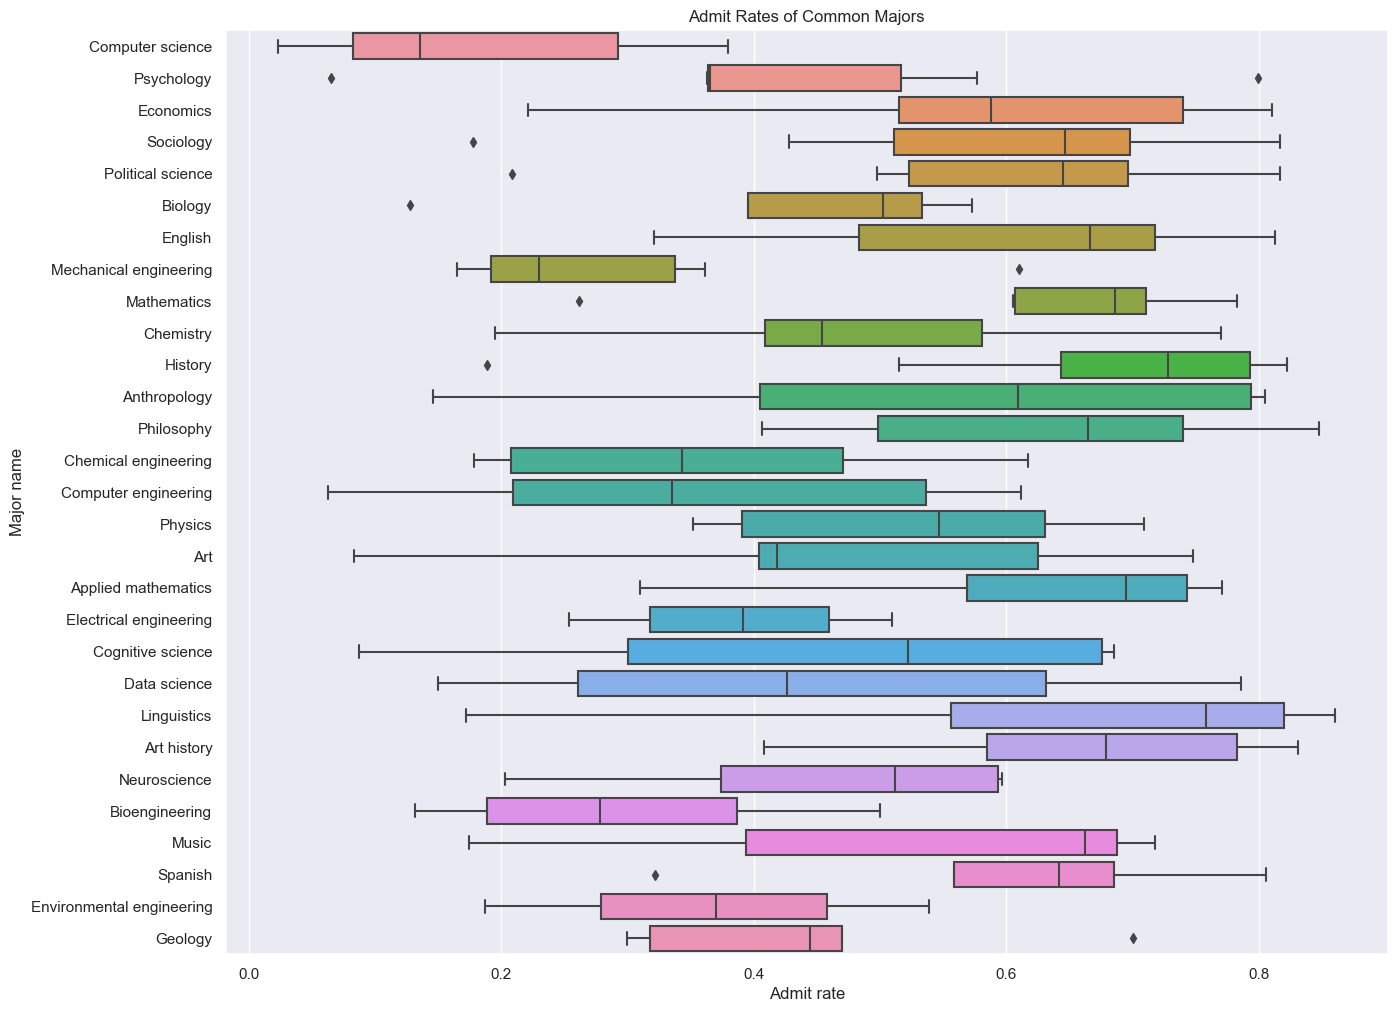

In [236]:
import seaborn as sns

# Plot major admit rates with majors sorted by 
# total number of applicants from low to high
sns.boxplot(data=tot_majors2, x='Admit rate', y='Major name').set(title='Admit Rates of Common Majors')
print('')

In [248]:
# Interactive plot of lower GPA admit limit per major 
# with UC's sorted by acceptance rate from low to high
drop_down_plot(pivot, title="Lower GPA Admit Limit of Most Common Majors by Campus") 

In [241]:
# Interactive plot of admit rate by major with 
# UC's sorted by acceptance rate from low to high
drop_down_plot(pivot2, title="Admit Rates Per Campus of Most Common Majors") 